In [1]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import davies_bouldin_score

Mounted at /content/drive


In [2]:
!pip install transformers

     |████████████████████████████████| 3.1 MB 4.0 MB/s 
     |████████████████████████████████| 3.3 MB 20.2 MB/s 
     |████████████████████████████████| 61 kB 608 kB/s 
     |████████████████████████████████| 895 kB 60.6 MB/s 
     |████████████████████████████████| 596 kB 84.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
import torch
from transformers import BertTokenizer, BertModel

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
% matplotlib inline

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [4]:
!pip install transformers pysentimiento

     |████████████████████████████████| 170 kB 5.7 MB/s 
     |████████████████████████████████| 298 kB 56.8 MB/s 
     |████████████████████████████████| 243 kB 87.7 MB/s 
     |████████████████████████████████| 1.1 MB 72.6 MB/s 
     |████████████████████████████████| 132 kB 88.6 MB/s 
     |████████████████████████████████| 160 kB 77.0 MB/s 
     |████████████████████████████████| 271 kB 89.4 MB/s 
     |████████████████████████████████| 192 kB 70.5 MB/s 
  Created wheel for emoji: filename=emoji-1.6.1-py3-none-any.whl size=169314 sha256=d8d3c9dea53ea76bb6408cbf564392b758d1543ffe0141059e5e8e6e301a004d
  Stored in directory: /root/.cache/pip/wheels/ea/5f/d3/03d313ddb3c2a1a427bb4690f1621eea60fe6f2a30cc95940f
Successfully built emoji


In [5]:
from transformers import pipeline, set_seed, AutoTokenizer, AutoModelForSequenceClassification
# from pysentimiento import SentimentAnalyzer,EmotionAnalyzer
from pysentimiento import create_analyzer
import requests
from bs4 import BeautifulSoup
import bleach
import re
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from nltk.tokenize import sent_tokenize
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import WordNetLemmatizer 
from sklearn.manifold import TSNE

In [6]:
from sklearn import svm
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

from sklearn import model_selection, metrics 
from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import HistGradientBoostingClassifier 

from sklearn import linear_model

/usr/local/lib/python3.7/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:17: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  "Since version 1.0, "


# Pre-precessing
1. drop duplicates, drop N/A, filter non-English
2. Show distribution of data

In [ ]:
df1 = pd.read_csv("/content/drive/MyDrive/data/Olympic2020_tweets.csv", sep=',',encoding='UTF-8')

result = df1["id"].unique()
print(len(df1["id"]))

print("去重之后的个数", len(result))

#drop duplicates 去重
data=df1.drop_duplicates(subset=['id'],keep='first',inplace=False)
data=df1.drop_duplicates(subset=['text'],keep='first',inplace=False)
#only original tweets 筛选is retweet是false的原创微博
data = data[data['is_retweet']==False] #159470 rows × 16 columns

# drop na 去空
data = data[['id','user_name','user_followers','user_verified','date','text','retweets','favorites','is_retweet']]
data = data.dropna() #159074 rows × 9 columns
# data#159074 rows × 9 columns
print("去空之后的个数", data.shape)



/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


297011
去重之后的个数 159493
去空之后的个数 (159074, 9)


In [ ]:
#expand dataset
df2 = pd.read_csv("/content/drive/MyDrive/data/data234_1.csv", sep=',',encoding='UTF-8')
df3 = pd.read_csv("/content/drive/MyDrive/data/data2560_1.csv", sep=',',encoding='UTF-8')

df = pd.concat([df1,df2,df3])

#drop duplicates 去重
data_dd=df.drop_duplicates(subset=['id'],keep='first',inplace=False)
data=data_dd.drop_duplicates(subset=['text'],keep='first',inplace=False)

#only original tweets 筛选is retweet是false的原创微博
data = data[data['is_retweet']==False] #159470 rows × 16 columns

# drop na 去空
data = data[['id','user_name','user_followers','user_verified','date','text','retweets','favorites','is_retweet']]
data = data.dropna()

print(data.shape) # 161826 rows × 9 columns

#输出当前数据到csv
# final_data = data.to_csv("/content/drive/MyDrive/data/FinalData.csv")

(161826, 9)


In [ ]:
#only English（过滤掉其他语言 删除不是英文的）
nltk.download('words')
words = set(nltk.corpus.words.words())
# for i in data
text = data['text'].tolist()
# print(len(text))
# print("xxxxxxxxxxxxxxxxx")
# en_text
en_text = []
for i in text:
  english = " ".join(w for w in nltk.wordpunct_tokenize(i) \
             if w.lower() in words or not w.isalpha())
  en_text.append(english)
len(en_text)


[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


161826

In [ ]:
#transfer non-english text list to Dataframe 再把去掉非英文文字之后的text转化成df
data['text']=pd.DataFrame(data=en_text)
data = data.dropna()

data = data[data['favorites']>1]
len(data) #56530 rows × 9 columns 最终的data数据

56530

## Distrbution of data

[ 4075 11865 17697 13131  6789  2603   370]


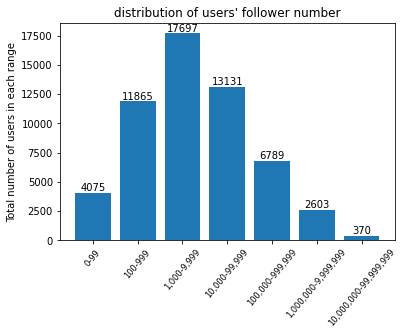

12928


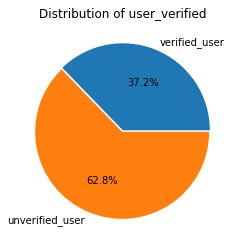

最大的转发量： 26164
retweet num is 0: 24709


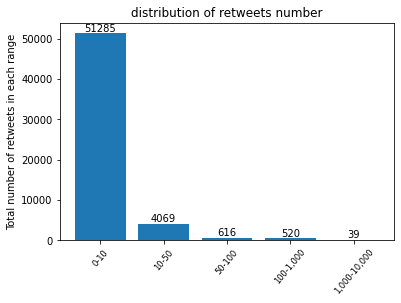

最大的点赞量： 106130
favorites num is 0: 0


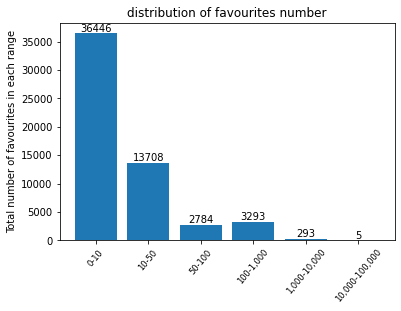

In [ ]:
# distribution of user_followers
followersnum = data["user_followers"]
followersnum = data["user_followers"].astype(int)#转化成整数，原来的数据有float有string比较杂乱
followersnum = np.array(followersnum)
fol_less100 = sum(followersnum<=100)#小于100的有3万多

# print(sorted(followersnum,reverse=False))#排序
# print(sum(followersnum==0))#计算一个值的个数
fol_0_100 = ((0 <= followersnum) & (followersnum < 100)).sum()#0-100---30707
fol_100_1000 =((100 <= followersnum) & (followersnum < 1000)).sum() #100-1000 58717
fol_1000_1w = ((1000 <= followersnum) & (followersnum < 10000)).sum()#1000-1w 41424
fol_1w_10w = ((10000 <= followersnum) & (followersnum < 100000)).sum()#1w-10w 16967
fol_10w_100w = ((100000 <= followersnum) & (followersnum < 1000000)).sum()#10w-100w 7673
fol_100w_1000w = ((1000000 <= followersnum) & (followersnum < 10000000)).sum()#100w-1000w 2586
fol_1000w_1y = ((10000000 <= followersnum) & (followersnum < 100000000)).sum()#1000w-1y 355

x = range(7)
y = np.array([fol_0_100, fol_100_1000, fol_1000_1w, fol_1w_10w, fol_10w_100w, fol_100w_1000w, fol_1000w_1y])
print(y)
x_label = ["0-99","100-999","1,000-9,999","10,000-99,999","100,000-999,999","1,000,000-9,999,999","10,000,000-99,999,999"]
plt.xticks(x,x_label,size="small",rotation=50)


plt.ylabel("Total number of users in each range")
for a,b in zip(x,y):
  plt.text(a, b+0.05, '%.0f' % b, ha='center', va= 'bottom',fontsize=10)
plt.title("distribution of users' follower number")
plt.bar(x,y)
plt.show()

# distribution of user_verified
verified = data["user_verified"]
verified_true = data[data["user_verified"]==True]
verified_false = data[data["user_verified"]==False]
verified_true_num = verified_true.shape[0]
verified_false_num = verified_false.shape[0]
print(verified_true_num)
label = ["verified_user","unverified_user"]
explode=[0.01,0.01]#设定各项距离圆心n个半径
values = [verified_true_num,verified_false_num]
plt.pie(values,explode=explode,labels=label,autopct='%1.1f%%')
plt.title("Distribution of user_verified")
plt.show()

# distribution of retweets
retweetsnum = data['retweets'].astype(int)#转化成整数，原来的数据有float有string比较杂乱
retweetsnum = np.array(retweetsnum)
print("最大的转发量：",retweetsnum.max())
print("retweet num is 0:",sum(retweetsnum==0))
ret_0_10 = ((0 <= retweetsnum) & (retweetsnum < 10)).sum()#0-10
ret_10_50 =((10 <= retweetsnum) & (retweetsnum < 50)).sum() #10-50
ret_50_100 = ((50 <= retweetsnum) & (retweetsnum < 100)).sum()#50-100 
ret_100_1000 = ((100 <= retweetsnum) & (retweetsnum < 1000)).sum()#100-1000
ret_1000_1w = ((1000 <= retweetsnum) & (retweetsnum < 10000)).sum()#1000-1w

x = range(5)
y = np.array([ret_0_10, ret_10_50, ret_50_100, ret_100_1000, ret_1000_1w])

x_label = ["0-10","10-50","50-100","100-1,000","1,000-10,000"]
plt.xticks(x,x_label,size="small",rotation=50)


plt.ylabel("Total number of retweets in each range")
for a,b in zip(x,y):
  plt.text(a, b+0.05, '%.0f' % b, ha='center', va= 'bottom',fontsize=10)
plt.title("distribution of retweets number")
plt.bar(x,y)
plt.show()

# distribution of favourites
likesnum = data['favorites'].astype(int)#转化成整数，原来的数据有float有string比较杂乱
likesnum = np.array(likesnum)
print("最大的点赞量：",likesnum.max())
print("favorites num is 0:",sum(likesnum==0))
like_0_10 = ((0 <= likesnum) & (likesnum < 10)).sum()#0-10
like_10_50 =((10 <= likesnum) & (likesnum < 50)).sum() #10-50
like_50_100 = ((50 <= likesnum) & (likesnum < 100)).sum()#50-100 41424
like_100_1000 = ((100 <= likesnum) & (likesnum < 1000)).sum()#100-1000 16967
like_1000_1w = ((1000 <= likesnum) & (likesnum < 10000)).sum()#1000-1w 7673
like_1w_10w = ((10000 <= likesnum) & (likesnum < 100000)).sum()#1000-1w 7673


x = range(6)
y = np.array([like_0_10, like_10_50, like_50_100, like_100_1000, like_1000_1w, like_1w_10w])

x_label = ["0-10","10-50","50-100","100-1,000","1,000-10,000","10,000-100,000"]
plt.xticks(x,x_label,size="small",rotation=50)


plt.ylabel("Total number of favourites in each range")
for a,b in zip(x,y):
  plt.text(a, b+0.05, '%.0f' % b, ha='center', va= 'bottom',fontsize=10)
plt.title("distribution of favourites number")
plt.bar(x,y)
plt.show()

# Set a threshold for labels

In [ ]:
#linear model to calculate popular value of each tweet

# ground truth give a label to each tweet 给每一条tweet贴标签
#现在把点赞数大于1000的以及转发数大于800的刨除，因为可以肯定他们时候受欢迎的
data_exceptlarge = data[(data['favorites']<500) & (data['retweets']<300)]
print("除去点赞数大于500，且转发数大于300的剩下的数：", len(data_exceptlarge))#55793
likesnum = data_exceptlarge['favorites'].astype(int)#转化成整数，原来的数据有float有string比较杂乱
likesnum = np.array(likesnum)
likenum_ave = likesnum.mean()

retweetsnum = data_exceptlarge['retweets'].astype(int)#转化成整数，原来的数据有float有string比较杂乱
retweetsnum = np.array(retweetsnum)
retweet_ave = retweetsnum.mean()

w1_f = likenum_ave/(likenum_ave + retweet_ave)#0.8485290095162455
w2_r = retweet_ave/(likenum_ave + retweet_ave)#0.15147099048375443
#popularity = w1*f+w2*r
data_exceptlarge['pop_value'] = w1_f*(data_exceptlarge['favorites'])+w2_r*(data_exceptlarge['retweets'])
print("popularity的最大值：",data_exceptlarge['pop_value'].max())

pop_value_array = np.array(data_exceptlarge['pop_value'])
#这里得到了popularity的值用于聚类！！
pop_value_2d = pop_value_array.reshape(-1,1) #变成了2d但是有一个维度是空的

除去点赞数大于500，且转发数大于300的剩下的数： 55793
popularity的最大值： 455.674845161673


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Kmeans for clustering

kmeans中unpopluar的个数： 53579
两个中心点是： [[ 11.55071059]
 [210.99797673]]
阈值是： 111.27434365815994
当前用到的数据集的shape： (56530, 11)
popular的个数： id                2951
user_name         2951
user_followers    2951
user_verified     2951
date              2951
text              2951
retweets          2951
favorites         2951
is_retweet        2951
pop_value         2214
pop_label         2951
dtype: int64


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

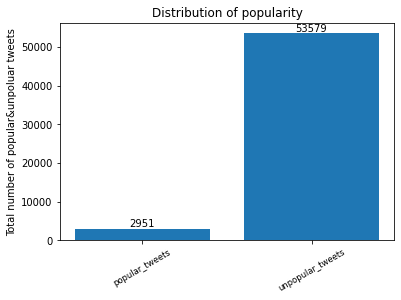

In [ ]:

#K-MEANS对一维数组聚类：核心的操作是y = x.reshape(-1,1)，含义为将一维数据变成只有1列，行数不知道多少（-1代表根据剩下的维度计算出数组的另外一个shape属性值）

kmeans = KMeans(n_clusters=2)
kmeans.fit(pop_value_2d)
labels_kmeans = kmeans.labels_
print("kmeans中unpopluar的个数：", sum(labels_kmeans==0))#53579
centers = kmeans.cluster_centers_
print("两个中心点是：",centers)
ave_center = centers.mean()
print("阈值是：",ave_center)
#把大于阈值的设为1，popular 小于的设为0，unpopular
data_exceptlarge.loc[data_exceptlarge.pop_value>=ave_center, 'pop_label'] = 1
data_exceptlarge.loc[data_exceptlarge.pop_value<ave_center, 'pop_label'] = 0

data_exceptlarge_index = data_exceptlarge.index.to_list()

# data_large = data[~data.index.isin(data_exceptlarge_index)]
data_large = data[(data['favorites']>=500) | (data['retweets']>=300)]
###########将data合并，得到pop_label的值为0和1
data_large['pop_label']=1
data_labeled_KM = pd.concat([data_exceptlarge,data_large],ignore_index=True) 
print("当前用到的数据集的shape：",data_labeled_KM.shape)

## distribution of popular and unpopular

popnum = data_labeled_KM[data_labeled_KM['pop_label']==1].shape[0]
unpopnum = data_labeled_KM[data_labeled_KM['pop_label']==0].shape[0]
print("popular的个数：",data_labeled_KM[data_labeled_KM['pop_label']==1.0].count())
# print(len(data_labeled))
x = range(2)
y = np.array([popnum,unpopnum])

x_label = ["popular_tweets","unpopular_tweets"]
plt.xticks(x,x_label,size="small",rotation=30)

plt.ylabel("Total number of popular&unpoluar tweets")
for a,b in zip(x,y):
  plt.text(a, b+0.05, '%.0f' % b, ha='center', va= 'bottom',fontsize=10)
plt.title("Distribution of popularity")
plt.bar(x,y)
plt.show()#2951和53579

### GMM for clsutering

四个协方差的labels full [array([0, 0, 0, ..., 1, 0, 1])]
阈值是： 33.036058693628945
受欢迎的， 7908


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

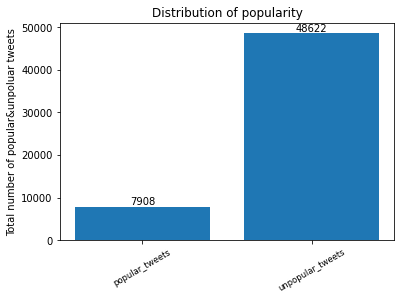

四个协方差的labels diag [array([0, 0, 0, ..., 1, 0, 1]), array([0, 0, 0, ..., 1, 0, 1])]
阈值是： 33.036058693628135
受欢迎的， 7908


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

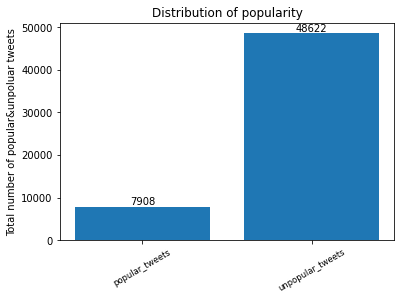

四个协方差的labels spherical [array([0, 0, 0, ..., 1, 0, 1]), array([0, 0, 0, ..., 1, 0, 1]), array([0, 0, 0, ..., 1, 0, 1])]
阈值是： 33.036058693628135
受欢迎的， 7908


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

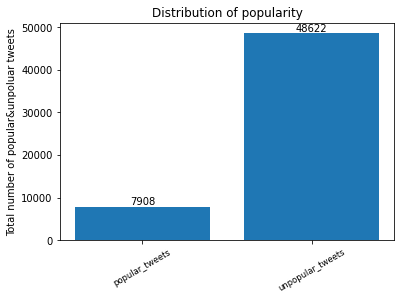

四个协方差的labels tied [array([0, 0, 0, ..., 1, 0, 1]), array([0, 0, 0, ..., 1, 0, 1]), array([0, 0, 0, ..., 1, 0, 1]), array([0, 0, 0, ..., 0, 0, 0])]
阈值是： 121.08251499715193
受欢迎的， 2738


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

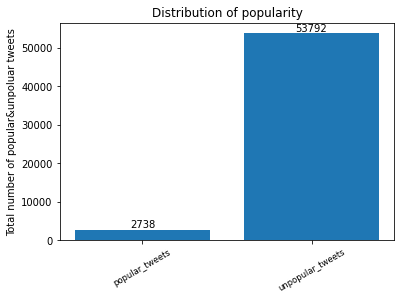

In [ ]:
from sklearn.mixture import GaussianMixture
covariance_t =['full','diag','spherical','tied']

labels_gmm = []#用于保存四个covariance的聚类结果
for i in covariance_t:
  gmm = GaussianMixture(n_components=2,covariance_type=i,max_iter=20, random_state=0).fit(pop_value_2d)
  #pop 14776
  # gmm = GaussianMixture(n_components=2,covariance_type='diag',max_iter=20, random_state=0).fit(pop_value_2d)
  # gmm = GaussianMixture(n_components=2,covariance_type='spherical',max_iter=20, random_state=0).fit(pop_value_2d)
  labels = gmm.predict(pop_value_2d)
  labels_gmm.append(labels)
  print("四个协方差的labels",i,labels_gmm)
  #把大于阈值的设为1，popular 小于的设为0，unpopular
  ave_center = gmm.means_.mean()
  print("阈值是：",ave_center)
  #把大于阈值的设为1，popular 小于的设为0，unpopular
  data_exceptlarge.loc[data_exceptlarge.pop_value>=ave_center, 'pop_label'] = 1
  data_exceptlarge.loc[data_exceptlarge.pop_value<ave_center, 'pop_label'] = 0


  # data_exceptlarge['pop_label'] = labels_gmm
  data_exceptlarge_index = data_exceptlarge.index.to_list()

  # data_large = data[(data['favorites']>=500) | (data['retweets']>=300)]
  ###########将data合并，得到pop_label的值为0和1
  data_large['pop_label']=1
  data_labeled_GMM = pd.concat([data_exceptlarge,data_large],ignore_index=True) 
  popnum = data_labeled_GMM[data_labeled_GMM['pop_label']==1].shape[0]
  unpopnum = data_labeled_GMM[data_labeled_GMM['pop_label']==0].shape[0]
  print("受欢迎的，",popnum)

  # print(len(data_labeled))
  x = range(2)
  y = np.array([popnum,unpopnum])

  x_label = ["popular_tweets","unpopular_tweets"]
  plt.xticks(x,x_label,size="small",rotation=30)


  plt.ylabel("Total number of popular&unpoluar tweets")
  for a,b in zip(x,y):
    plt.text(a, b+0.05, '%.0f' % b, ha='center', va= 'bottom',fontsize=10)
  plt.title("Distribution of popularity")
  plt.bar(x,y)
  plt.show()

## Evaluate the threshold

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

### Evaluate Kmeans

In [ ]:
#silhouette_score(思路艾特)
result_list = kmeans.fit_predict(pop_value_2d)
# print(len(result_list))
# plt.scatter(pop_value_2d[:, 0],y= np.full( shape=158429, fill_value=3, dtype=np.int),s=1,c=result_list)
score = silhouette_score(pop_value_2d, result_list)
score

0.9018295022381785

In [ ]:
#DBI davies_bouldin_score

labels_kmeans = kmeans.labels_
davies_bouldin_score(pop_value_2d, labels_kmeans)
# sum(labels==0)

0.4094627991180788

### Evaluate GMM

In [ ]:
# (思路艾特)

#labels_gmm
#顺序依次：['full','diag','spherical','tied']
for i in labels_gmm:
  score = silhouette_score(pop_value_2d, i)
  print(score)

0.6410564355662827
0.6410564355662827
0.6410564355662827
0.9059495725669343


In [ ]:
#DBI davies_bouldin_score
#顺序依次：[['full','diag','spherical','tied']
for i in labels_gmm:
  score = davies_bouldin_score(pop_value_2d, i)
  print(score)

0.8898912828977829
0.8898912828977829
0.8898912828977829
0.369355152884217


##distribution of popular tweets 
After comparing， the most suitable threshold is from GMM with "tied".
The final labels are saved in dataframe '*data_labeled*'.

受欢迎的， 2738
最大的转发量： 26164
retweet num is 0: 6


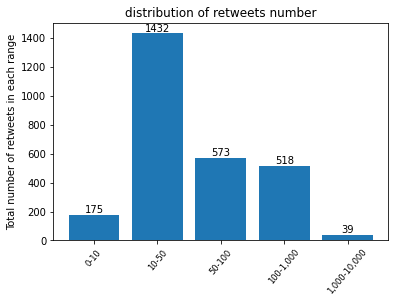

最大的点赞量： 106130
favorites num is 0: 0


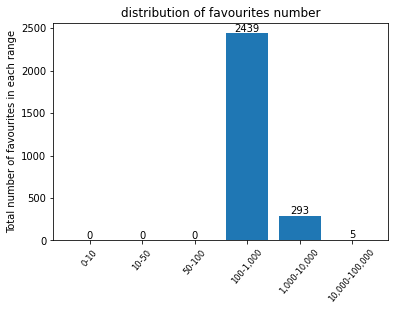

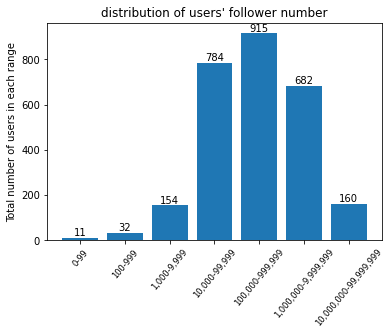

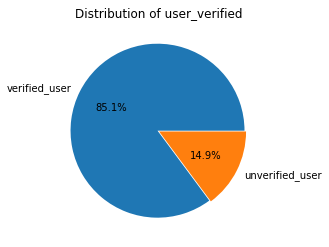

In [ ]:
print("受欢迎的，",popnum)
#1 rewteets转发量
data_pop = data_labeled_GMM[data_labeled_GMM['pop_label']==1]
# print("popular tweets",data_pop.count())
retweetsnum_pop = data_pop['retweets'].astype(int)#转化成整数，原来的数据有float有string比较杂乱
retweetsnum_pop = np.array(retweetsnum_pop)
print("最大的转发量：",retweetsnum_pop.max())
print("retweet num is 0:",sum(retweetsnum_pop==0))
ret__pop_0_10 = ((0 <= retweetsnum_pop) & (retweetsnum_pop < 10)).sum()#0-10
ret_pop_10_50 =((10 <= retweetsnum_pop) & (retweetsnum_pop < 50)).sum() #10-50
ret_pop_50_100 = ((50 <= retweetsnum_pop) & (retweetsnum_pop < 100)).sum()#50-100 
ret_pop_100_1000 = ((100 <= retweetsnum_pop) & (retweetsnum_pop < 1000)).sum()#100-1000
ret_pop_1000_1w = ((1000 <= retweetsnum_pop) & (retweetsnum_pop < 10000)).sum()#1000-1w

x1 = range(5)
y1 = np.array([ret__pop_0_10, ret_pop_10_50, ret_pop_50_100, ret_pop_100_1000, ret_pop_1000_1w])
x_label = ["0-10","10-50","50-100","100-1,000","1,000-10,000"]
plt.xticks(x1,x_label,size="small",rotation=50)
plt.ylabel("Total number of retweets in each range")
for a,b in zip(x1,y1):
  plt.text(a, b+0.05, '%.0f' % b, ha='center', va= 'bottom',fontsize=10)
plt.title("distribution of retweets number")
# plt.subplot(421)
plt.bar(x1,y1)
plt.show()
##2 favorites点赞量
likesnum = data_pop['favorites'].astype(int)#转化成整数，原来的数据有float有string比较杂乱
likesnum = np.array(likesnum)
print("最大的点赞量：",likesnum.max())
print("favorites num is 0:",sum(likesnum==0))
like_0_10 = ((0 <= likesnum) & (likesnum < 10)).sum()#0-10
like_10_50 =((10 <= likesnum) & (likesnum < 50)).sum() #10-50
like_50_100 = ((50 <= likesnum) & (likesnum < 100)).sum()#50-100 41424
like_100_1000 = ((100 <= likesnum) & (likesnum < 1000)).sum()#100-1000 16967
like_1000_1w = ((1000 <= likesnum) & (likesnum < 10000)).sum()#1000-1w 7673
like_1w_10w = ((10000 <= likesnum) & (likesnum < 100000)).sum()#1000-1w 7673


x2 = range(6)
y2 = np.array([like_0_10, like_10_50, like_50_100, like_100_1000, like_1000_1w, like_1w_10w])

x_label_2 = ["0-10","10-50","50-100","100-1,000","1,000-10,000","10,000-100,000"]
plt.xticks(x2,x_label_2,size="small",rotation=50)


plt.ylabel("Total number of favourites in each range")
for a,b in zip(x2,y2):
  plt.text(a, b+0.05, '%.0f' % b, ha='center', va= 'bottom',fontsize=10)
plt.title("distribution of favourites number")
# plt.subplot(424)
plt.bar(x2,y2)
plt.show()

##3 粉丝数
followersnum = data_pop["user_followers"]
followersnum = data_pop["user_followers"].astype(int)#转化成整数，原来的数据有float有string比较杂乱
followersnum = np.array(followersnum)
fol_less100 = sum(followersnum<=100)#小于100的有3万多

# print(sorted(followersnum,reverse=False))#排序
# print(sum(followersnum==0))#计算一个值的个数
fol_0_100 = ((0 <= followersnum) & (followersnum < 100)).sum()#0-100---30707
fol_100_1000 =((100 <= followersnum) & (followersnum < 1000)).sum() #100-1000 58717
fol_1000_1w = ((1000 <= followersnum) & (followersnum < 10000)).sum()#1000-1w 41424
fol_1w_10w = ((10000 <= followersnum) & (followersnum < 100000)).sum()#1w-10w 16967
fol_10w_100w = ((100000 <= followersnum) & (followersnum < 1000000)).sum()#10w-100w 7673
fol_100w_1000w = ((1000000 <= followersnum) & (followersnum < 10000000)).sum()#100w-1000w 2586
fol_1000w_1y = ((10000000 <= followersnum) & (followersnum < 100000000)).sum()#1000w-1y 355

x3 = range(7)
y3 = np.array([fol_0_100, fol_100_1000, fol_1000_1w, fol_1w_10w, fol_10w_100w, fol_100w_1000w, fol_1000w_1y])
# print(y)
x_label_3 = ["0-99","100-999","1,000-9,999","10,000-99,999","100,000-999,999","1,000,000-9,999,999","10,000,000-99,999,999"]
plt.xticks(x3,x_label_3,size="small",rotation=50)


plt.ylabel("Total number of users in each range")
for a,b in zip(x3,y3):
  plt.text(a, b+0.05, '%.0f' % b, ha='center', va= 'bottom',fontsize=10)
plt.title("distribution of users' follower number")
# plt.subplot(425)
plt.bar(x3,y3)
plt.show()


##4 用户认证
# distribution of user_verified
verified = data_pop["user_verified"]
verified_true = data_pop[data_pop["user_verified"]==True]
verified_false = data_pop[data_pop["user_verified"]==False]
verified_true_num = verified_true.shape[0]
verified_false_num = verified_false.shape[0]
# print(verified_true_num)
label = ["verified_user","unverified_user"]
explode=[0.01,0.01]#设定各项距离圆心n个半径
values = [verified_true_num,verified_false_num]
# plt.subplot(428)
plt.pie(values,explode=explode,labels=label,autopct='%1.1f%%')
plt.title("Distribution of user_verified")

plt.show()

# NLP

### Process text
remove mention, hashtag, "\n"

In [ ]:
#remove URL 移除text中的URL
print(data_labeled_GMM["text"].values[19])

def process(x):
    x = re.sub("(http|https):\/\/([\w.]+\/?)\S*", "", x)
    return x

data_labeled_GMM["text"] = data_labeled_GMM["text"].apply(process)
# len(data["text"].values[0])
# print(data["text"].values[19])

It ' be an early rise tomorrow when the action 🙌 Here ' s a up on when @ & ; @ will … :// t . / IJHNXxqWR5


In [ ]:
#remove @#\n 删除@#\n
text = pd.DataFrame(data_labeled_GMM['text'])
# print(data["text"].values[2555])
def process(x):
  x = re.sub("(回复)?(//)?\s*@\S*?\s*(:| |$)"," ",x)#删除@和后面的名字
  x = re.sub('[#&]',"",x)
  a = re.sub('\n',".",x) #删除\n
  return a

data_labeled_GMM["text"] = data_labeled_GMM["text"].apply(process)
data_labeled_GMM["text"]

0        The wait for a medal is over ! 👏🥈 ' s medal ac...
1        : cash prize for who help win at Read ANI Stor...
2        Complete Schedule for ' s and Men ' s Hockey a...
3        cricket fraternity for the Silver medal at 202...
4        on the steel . He sticks his landing !  Tokyo2...
                               ...                        
56525    Does anyone know why ' t or even a sub ?   Tok...
56526    Best of luck for all the who r in  Olympics202...
56527     :  ( 49kg ) become the first   to win silver ...
56528    4 - 2 against and they are in the next round i...
56529    had an awful last leg there and could be out  ...
Name: text, Length: 56530, dtype: object

###Text information
将text用BERT转化成词向量

In [ ]:
# Add tokenization[CLS],[SEP]
all_text = data_labeled_GMM["text"]
text_list_add2 = []
for i in all_text:
  # print(i)
  marked_text = "[CLS] " + i + " [SEP]"
  text_list_add2.append(marked_text)
# print (text_list_add2[0])

In [ ]:
tensors_list=[]
for i in text_list_add2:
  tokenized_text = tokenizer.tokenize(i)
  indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
  #BERT接受过句子对的训练，期望使用1和0来区分这两个句子。
  segments_ids = [1] * len(tokenized_text)
  # print (len(segments_ids))
  # Convert inputs to PyTorch tensors
  tokens_tensor = torch.tensor([indexed_tokens])
  segments_tensors = torch.tensor([segments_ids])
  tensors_list.append([tokens_tensor,segments_tensors])


In [ ]:
 # Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased',output_hidden_states = True)
model.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

##Sentence vectors by BERT(从这里分开运行)

In [ ]:
# 1-1w的数据得到bert（没有删除表情）
#接下来，让我们获取网络的隐藏状态。
# Torch.no_Grad关闭梯度计算，节省内存，并加快计算速度（我们不需要梯度或反向传播，因为我们只是向前传播）
tensors_list_part = tensors_list[0:10000]
sent_emb = []
with torch.no_grad():
  for i in tensors_list_part:
    outputs = model(i[0], i[1])

    # Evaluating the model will return a different number of objects based on 
    # how it's  configured in the `from_pretrained` call earlier. In this case, 
    # becase we set `output_hidden_states = True`, the third item will be the 
    # hidden states from all layers. See the documentation for more details:
    # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
    hidden_states = outputs[2]
    token_vecs = hidden_states[-2][0]
    # Calculate the average of all 22 token vectors.
    sentence_embedding = torch.mean(token_vecs, dim=0)
    # print ("Our final sentence embedding vector of shape:", sentence_embedding.size())
    sent_emb.append(sentence_embedding)
sent_emb = pd.DataFrame(sent_emb)
s1 = sent_emb.to_csv("/content/drive/MyDrive/data/s1.csv")

In [ ]:
# 1w-2.5w的数据得到bert
#接下来，让我们获取网络的隐藏状态。
# Torch.no_Grad关闭梯度计算，节省内存，并加快计算速度（我们不需要梯度或反向传播，因为我们只是向前传播）
tensors_list_part2 = tensors_list[10000:25000]
sent_emb2 = []
with torch.no_grad():
  for i in tensors_list_part2:
    outputs = model(i[0], i[1])

    # Evaluating the model will return a different number of objects based on 
    # how it's  configured in the `from_pretrained` call earlier. In this case, 
    # becase we set `output_hidden_states = True`, the third item will be the 
    # hidden states from all layers. See the documentation for more details:
    # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
    hidden_states = outputs[2]
    token_vecs = hidden_states[-2][0]
    # Calculate the average of all 22 token vectors.
    sentence_embedding = torch.mean(token_vecs, dim=0)
    # print ("Our final sentence embedding vector of shape:", sentence_embedding.size())
    sent_emb2.append(sentence_embedding)
sent_emb2 = pd.DataFrame(sent_emb2)
s2 = sent_emb2.to_csv("/content/drive/MyDrive/data/s2.csv")

In [ ]:
# 2.5w-4w的数据得到bert

#接下来，让我们获取网络的隐藏状态。
# Torch.no_Grad关闭梯度计算，节省内存，并加快计算速度（我们不需要梯度或反向传播，因为我们只是向前传播）
tensors_list_part3 = tensors_list[25000:40000]
sent_emb3 = []
with torch.no_grad():
  for i in tensors_list_part3:
    outputs = model(i[0], i[1])

    # Evaluating the model will return a different number of objects based on 
    # how it's  configured in the `from_pretrained` call earlier. In this case, 
    # becase we set `output_hidden_states = True`, the third item will be the 
    # hidden states from all layers. See the documentation for more details:
    # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
    hidden_states = outputs[2]
    token_vecs = hidden_states[-2][0]
    # Calculate the average of all 22 token vectors.
    sentence_embedding = torch.mean(token_vecs, dim=0)
    # print ("Our final sentence embedding vector of shape:", sentence_embedding.size())
    sent_emb3.append(sentence_embedding)
sent_emb3 = pd.DataFrame(sent_emb3)
s3 = sent_emb3.to_csv("/content/drive/MyDrive/data/s3.csv")

In [ ]:
#接下来，让我们获取网络的隐藏状态。
# Torch.no_Grad关闭梯度计算，节省内存，并加快计算速度（我们不需要梯度或反向传播，因为我们只是向前传播）
tensors_list_part4 = tensors_list[40000:]
sent_emb4 = []
with torch.no_grad():
  for i in tensors_list_part4:
    outputs = model(i[0], i[1])

    # Evaluating the model will return a different number of objects based on 
    # how it's  configured in the `from_pretrained` call earlier. In this case, 
    # becase we set `output_hidden_states = True`, the third item will be the 
    # hidden states from all layers. See the documentation for more details:
    # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
    hidden_states = outputs[2]
    token_vecs = hidden_states[-2][0]
    # Calculate the average of all 22 token vectors.
    sentence_embedding = torch.mean(token_vecs, dim=0)
    # print ("Our final sentence embedding vector of shape:", sentence_embedding.size())
    sent_emb4.append(sentence_embedding)
sent_emb4 = pd.DataFrame(sent_emb4)
s4 = sent_emb4.to_csv("/content/drive/MyDrive/data/s4.csv")

### upload senetence vectors in csv上传读取四个文件csv，转化为向量
It is because to train the whole data needs large size of RAM, so I divide it into 4 parts and save them into csv files


In [7]:
##把dataframe转化成tensor

s1 = pd.read_csv("/content/drive/MyDrive/data/s1.csv")
s1 = pd.DataFrame(s1)
s2 = pd.read_csv("/content/drive/MyDrive/data/s2.csv")
s2 = pd.DataFrame(s2)
s3 = pd.read_csv("/content/drive/MyDrive/data/s3.csv")
s3 = pd.DataFrame(s3)
s4 = pd.read_csv("/content/drive/MyDrive/data/s4.csv")
s4 = pd.DataFrame(s4)
sente_vec = s1.append([s2,s3,s4])
sente_vec

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
0,0,tensor(-0.0126),tensor(-0.3415),tensor(0.7318),tensor(-0.4919),tensor(-0.2161),tensor(-0.1609),tensor(0.1881),tensor(0.4270),tensor(-0.3544),tensor(0.0532),tensor(-0.3411),tensor(-0.0851),tensor(0.3937),tensor(0.3979),tensor(0.0336),tensor(0.4489),tensor(-0.1718),tensor(0.2843),tensor(0.1745),tensor(0.1361),tensor(0.7350),tensor(0.3784),tensor(0.2601),tensor(0.0253),tensor(0.4428),tensor(0.1500),tensor(-0.2805),tensor(-0.0334),tensor(-0.4366),tensor(-0.0491),tensor(0.0499),tensor(-0.1316),tensor(0.1968),tensor(0.1259),tensor(-0.3452),tensor(-0.6103),tensor(-0.4005),tensor(0.0078),tensor(0.4726),...,tensor(-0.5594),tensor(-0.4769),tensor(-0.1769),tensor(0.0861),tensor(-0.0099),tensor(-0.4535),tensor(-0.1554),tensor(-0.0394),tensor(-0.0603),tensor(0.0457),tensor(0.1789),tensor(0.1962),tensor(0.4480),tensor(0.0021),tensor(-0.2509),tensor(-0.1840),tensor(-0.0024),tensor(0.3119),tensor(0.0876),tensor(0.0104),tensor(-0.0072),tensor(0.4137),tensor(0.0248),tensor(-0.0070),tensor(-0.2196),tensor(0.1819),tensor(0.0341),tensor(0.0572),tensor(-0.7066),tensor(-0.6761),tensor(-0.0776),tensor(0.0001),tensor(-0.2861),tensor(-0.3803),tensor(0.1009),tensor(0.2591),tensor(-0.4823),tensor(-0.1831),tensor(-0.2428),tensor(0.2236)
1,1,tensor(-0.0607),tensor(-0.3030),tensor(0.6797),tensor(-0.2701),tensor(0.5572),tensor(0.0032),tensor(0.6089),tensor(0.4248),tensor(-0.2656),tensor(0.1968),tensor(-0.2299),tensor(-0.4006),tensor(0.3628),tensor(0.2597),tensor(0.0412),tensor(0.7663),tensor(0.1778),tensor(0.3038),tensor(-0.3223),tensor(0.2208),tensor(0.5223),tensor(0.1389),tensor(0.1949),tensor(0.2340),tensor(0.1652),tensor(0.2905),tensor(0.2805),tensor(-0.2373),tensor(-0.5824),tensor(-0.2229),tensor(0.2515),tensor(-0.2126),tensor(0.3621),tensor(-0.3063),tensor(-0.3137),tensor(-0.3411),tensor(-0.3799),tensor(0.0075),tensor(0.5144),...,tensor(-0.2419),tensor(-0.8309),tensor(0.0367),tensor(0.1090),tensor(0.0117),tensor(-0.5704),tensor(-0.4520),tensor(-0.0309),tensor(-0.2550),tensor(-0.1901),tensor(-0.0356),tensor(0.3077),tensor(0.3792),tensor(0.1238),tensor(-0.4183),tensor(-0.2337),tensor(-0.1450),tensor(0.3766),tensor(0.0378),tensor(0.3647),tensor(-0.0476),tensor(0.0892),tensor(0.3453),tensor(0.2928),tensor(-0.1469),tensor(0.1754),tensor(0.3131),tensor(-0.1288),tensor(-0.7360),tensor(-0.7517),tensor(-0.2738),tensor(0.1998),tensor(-0.2159),tensor(-0.2663),tensor(-0.0151),tensor(0.5603),tensor(-0.3315),tensor(-0.4532),tensor(-0.2609),tensor(0.2813)
2,2,tensor(-0.0880),tensor(-0.5577),tensor(0.3805),tensor(-0.1640),tensor(0.0515),tensor(-0.4566),tensor(0.1755),tensor(0.5674),tensor(-0.2602),tensor(-0.2600),tensor(-0.0597),tensor(-0.1181),tensor(0.2190),tensor(-0.0005),tensor(0.2302),tensor(0.4858),tensor(0.0570),tensor(0.6422),tensor(0.3296),tensor(0.1657),tensor(0.8055),tensor(-0.0663),tensor(0.1019),tensor(0.2130),tensor(0.2349),tensor(0.3735),tensor(-0.2580),tensor(-0.0462),tensor(-0.6669),tensor(-0.2956),tensor(0.3578),tensor(-0.2041),tensor(0.5932),tensor(-0.0098),tensor(-0.4542),tensor(-0.6678),tensor(-0.3866),tensor(0.1730),tensor(0.2261),...,tensor(-0.2882),tensor(-0.6963),tensor(0.2586),tensor(0.5108),tensor(-0.2951),tensor(-0.6086),tensor(-0.1806),tensor(0.0204),tensor(-0.2476),tensor(0.1652),tensor(-0.0273),tensor(-0.1263),tensor(0.3169),tensor(0.3425),tensor(-0.4323),tensor(-0.3351),tensor(-0.5597),tensor(0.2720),tensor(0.4516),tensor(-0.0916),tensor(-0.0846),tensor(0.2941),tensor(0.2792),tensor(-0.1116),tensor(0.0423),tensor(0.4085),tensor(-0.0520),tensor(0.2048),tensor(-0.6307),tensor(-0.2925),tensor(0.1360),tensor(-0.0074),tensor(-0.0698),tensor(0.0098),tensor(0.0645),tensor(-0.1231),tensor(-0.2735),tensor(0.0412),tensor(-0.0866),tensor(0.0048)
3,3,tensor(0.2593),t

In [8]:
import torch
def string2tensor(s):
  # s = s[6:]
  # s = s[1:-1]
  # s = s.split(',')
  # print(s)
  s = re.findall(r"[(](.*?)[)]", s)
  emb = []
  for i in s:
    emb.append(float(i))
  emb = torch.tensor(emb, dtype=torch.float32)
  return emb

svec = sente_vec.iloc[:,1:]
# print(svec.iloc[1])
print(len(svec))
sente_vec_bert = []
for i in range(len(svec)):
  row = svec.iloc[i]
  row = row.to_string()
  a = string2tensor(row)
  sente_vec_bert.append(a)


# for index, row in sente_vec.iterrows():
#   row = str(row)
#   a = string2tensor(row)
#   print(a)

56530


## Reduce Dimention（降维PCA）

In [10]:
#sente_vec_bert 768的句向量
svec_bert_arr = np.array(sente_vec_bert[0])
# svec_bert_arr
for i in sente_vec_bert[1:]:
  sen_arr = np.array(i)#其中的一个tweet的向量
  # print(sen_arr)
  svec_bert_arr = np.append(svec_bert_arr,sen_arr)
svec_bert_arr.shape#43415040


(43415040,)

In [11]:
#################修改版
print(svec_bert_arr.shape)
svec_bert_arr = svec_bert_arr.reshape(56530,768)
##standard 标准化
mean = svec_bert_arr.mean(axis=0)#axis=0是列与列之间进行的运算
deviation = svec_bert_arr.std(axis=0)#标准差
standardized = (svec_bert_arr-mean)/deviation

##PCA
covMat = np.cov(standardized, rowvar=False)
# print(covMat)
featValue, featVec = np.linalg.eig(covMat) 
index = np.argsort(featValue)[::-1] #从大到小排列特征值

per_value_sum = 0
n_components =np.array([1,1,1,1,1,1,1,1,1,1])
for i in index:
    per_value_sum += featValue[i]
    if per_value_sum/np.sum(featValue) < 0.1:#1
        n_components[0] +=1
    if per_value_sum/np.sum(featValue) < 0.15:#2
        n_components[1] +=1 
    if per_value_sum/np.sum(featValue) < 0.2:#3
        n_components[2] +=1
    if per_value_sum/np.sum(featValue) < 0.26:#4
        n_components[3] +=1
    if per_value_sum/np.sum(featValue) < 0.3:#5
        n_components[4] +=1
    if per_value_sum/np.sum(featValue) < 0.33:#6
        n_components[5] +=1
    if per_value_sum/np.sum(featValue) < 0.36:#7
        n_components[6] +=1
    if per_value_sum/np.sum(featValue) < 0.38:#8
        n_components[7] +=1
    if per_value_sum/np.sum(featValue) < 0.4:#9
        n_components[8] +=1
    if per_value_sum/np.sum(featValue) < 0.42:#10
        n_components[9] +=1
print(n_components)

#投影映射
text_lowd_all = []
vector_ordered = featVec[:,index] #把vector按从大到小排列
for i in n_components:
  projected = vector_ordered[:,:i]#排列好之后取前n_components个
  data_lowd = np.dot(standardized,projected)#取好的向量与标准化后的原数据点乘得到降维的数据
  text_lowd_all.append(data_lowd)
# data_lowd_all
# print("-----------data_lowd-----------")
# print(text_lowd_all.shape)

(43415040,)
[ 1  2  3  4  5  6  7  8  9 10]


# sentiment analysis

In [ ]:
def sentiment_analysis(text_ls):
    analyzer = create_analyzer(task="sentiment", lang="en") #Define anlayzer
    text_ls = []
    for sent in tqdm(text_list_split):
      tmp = analyzer.predict(sent)
      probas = [] #Store all the probablities
      for p in tmp.probas:
          probas.append(tmp.probas[p])
      text_ls.append([tmp.output]+probas)
    text_ls = pd.DataFrame(text_ls,columns = ['output','NEU','POS','NEG'])
    return text_ls

## calculate polarity probability of each tweet

In [ ]:
text_list = data_labeled_GMM["text"].tolist()
# part = text_list[0:50]
# print(len(part))
# analyzer = SentimentAnalyzer(lang="en") #Define anlayzer
analyzer = create_analyzer(task="sentiment", lang="en")
text_ls = []

for i in tqdm(text_list):
    tmp = analyzer.predict(i)
    # print(tmp)
    probas = [] #Store all the probablities
    for p in tmp.probas:
      probas.append(tmp.probas[p])
    text_ls.append([tmp.output]+probas)

text_ls = pd.DataFrame(text_ls,columns = ['output','NEG','NEU','POS'])
display(text_ls)   

Downloading:   0%|          | 0.00/295 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/890 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/824k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/17.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/515M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/56530 [00:00<?, ?it/s]

,output,NEG,NEU,POS
0,NEU,0.004847,0.751594,0.243559
1,NEU,0.001428,0.804948,0.193624
2,NEU,0.001792,0.895586,0.102622
3,POS,0.001298,0.402061,0.596641
4,NEU,0.001824,0.895698,0.102477
...,...,...,...,...
56525,NEU,0.017014,0.975283,0.007704
56526,POS,0.000883,0.009521,0.989596
56527,NEU,0.010091,0.911002,0.078907
56528,NEU,0.001904,0.963706,0.034390


In [ ]:
# 保存情感极性结果到csv和data_labeled
data_labeled_GMM['polarity'] = text_ls['output']
data_labeled_GMM

f = data_labeled_GMM.to_csv("/content/drive/MyDrive/data/sentiment.csv")
# f1 = data_labeled_GMM.to_html("sentiment.html")

In [ ]:
data_labeled_GMM[data_labeled_GMM['polarity']=='POS'].count()

id                21889
user_name         21889
user_followers    21889
user_verified     21889
date              21889
text              21889
retweets          21889
favorites         21889
is_retweet        21889
pop_value         21607
pop_label         21889
polarity          21889
dtype: int64

In [12]:
all_data = pd.read_csv("/content/drive/MyDrive/data/sentiment.csv", sep=',',encoding='UTF-8')
all_data

,Unnamed: 0,id,user_name,user_followers,user_verified,date,text,retweets,favorites,is_retweet,pop_value,pop_label,polarity
0,0,1418889351405125634,#Tokyo2020 for India,38379.0,True,2021-07-24 11:02:37,The wait for a medal is over ! 👏🥈 ' s medal ac...,0.0,5.0,False,4.327629,0.0,NEU
1,1,1418889308337967104,ANI Digital,202601.0,True,2021-07-24 11:02:27,: cash prize for who help win at Read ANI Stor...,0.0,3.0,False,2.596577,0.0,NEU
2,2,1418889136560353282,PIB in Odisha,17808.0,True,2021-07-24 11:01:46,Complete Schedule for ' s and Men ' s Hockey a...,0.0,2.0,False,1.731052,0.0,NEU
3,3,1418889120781193216,CricTracker,183552.0,True,2021-07-24 11:01:42,cricket fraternity for the Silver medal at 202...,1.0,8.0,False,7.058680,0.0,POS
4,4,1418889102259273730,Gretchen Ho,900955.0,True,2021-07-24 11:01:38,on the steel . He sticks his landing ! Tokyo2...,11.0,32.0,False,29.176041,0.0,NEU
...,...,...,...,...,...,...,...,...,...,...,...,...,...
56525,56525,1452587417827823621,bee ❤ 10/22,6617.0,False,2021-10-25 10:46:42,Does anyone know why ' t or even a sub ? Tok...,219.0,522.0,False,NaN,1.0,NEU
56526,56526,1452580364459728898,Bandwagon,12753.0,True,2021-10-25 10:18:41,Best of luck for all the who r in Olympics202...,1083.0,4837.0,False,NaN,1.0,POS
56527,56527,1452567101319823361,World Athletics,329730.0,True,2021-10-25 09:25:59,: ( 49kg ) become the first to win silver ...,183.0,1231.0,False,NaN,1.0,NEU
56528,56528,1452541913886756867,State House Kenya,1452304.0,True,2021-10-25 07:45:53,4 - 2 against and they are in the next round i...,156.0,1106.0,False,NaN,1.0,NEU


# Predict Popularity

## Extract features 

In [13]:
#把特征中的string变成digits
all_data['user_verified'] =all_data[['user_verified']].astype('int')
mapping1 = {'POS':1, 'NEU':0, 'NEG':-1}
all_data['polarity'] = all_data['polarity'].map(mapping1)


In [14]:
###### 将content逐渐加入feature_list 生成新特征

print("popular的个数:")#2738
print(len(all_data[all_data['pop_label']==1]))#label=1 popular

feature_list=[]
for i in range(len(text_lowd_all)):
  features = all_data[['user_followers','user_verified','polarity']]
  # print(i)
  for j in range(text_lowd_all[i].shape[1]):
    features["emb_{}".format(j)] = text_lowd_all[i][:,j]
  # print("features!!!")
  feature_list.append(features)
# f = features.to_html("features.html")

popular的个数:
2738


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [15]:
#standardize features 对特征进行标准化（按列）
def standardize(X):  
    m, n = X.shape  
    # 归一化每一个特征  
    for j in range(n):  
        features = X[:,j]  
        meanVal = features.mean(axis=0)  
        std = features.std(axis=0)  
        if std != 0:  
            X[:, j] = (features-meanVal)/std  
        else:  
            X[:, j] = 0  
    return X  

## Divide dataset to train set and test set

In [16]:
#只分割 训练集和测试集 一次的代码
# from sklearn.model_selection import train_test_split
# features_arr = np.array(features)
# x, y = np.split(features_arr, (6,), axis=1)#前3列成为特征，后一列是标签
# # x = x[:, :2]
# x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1, train_size=0.8)
# #您可以使用sklearn.model_selection.train_test_split两次。首先拆分训练，测试，然后再将训练拆分为验证和训练。

In [16]:
from sklearn.model_selection import KFold,StratifiedKFold
y = all_data['pop_label'] #label
# for i in feature_list:
#   x = np.array(i)
#   # print(x)
#   y = all_data['pop_label']
sfolder = StratifiedKFold(n_splits=5,random_state=0,shuffle=True)
sfolder

StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

## Functions used in ML models

In [17]:
#添加sample_weight
def sample_weight_fun(x_train,y_train,pop_weight,unpop_weight): 
  sample_weight = np.ones(len(x_train))
  comb_xy = np.column_stack((sample_weight,y_train))
  pop = np.where(comb_xy[:,-1]==1)
  unpop = np.where(comb_xy[:,-1]==0)
  sample_weight[pop] *= pop_weight
  sample_weight[unpop] *= unpop_weight
  return sample_weight

In [18]:
def evaluation_metrics(model,x_train,y_train,x_test,y_test,y_predict):
    np.set_printoptions(suppress=True)
    con_mx = conf_matrix(y_test, y_predict)
    train_acc = model.score(x_train, y_train)
    test_acc = model.score(x_test, y_test)
    f1_macro = f1_score(y_test,y_predict, average='macro')
    f1_micro = f1_score(y_test,y_predict, average='micro')
    recall = recall_score(y_test, y_predict,average=None)
    precision =precision_score(y_test, y_predict,average=None)
    eval_score = np.array([train_acc,test_acc,con_mx[0],con_mx[1],con_mx[2],con_mx[3],f1_macro,f1_micro,recall[0],recall[1],precision[0],precision[1]])
    return eval_score

In [19]:
#confusion matrix
def conf_matrix(y,pred): 
    ((tn, fp), (fn, tp)) = metrics.confusion_matrix(y, pred) 
    ((tnr,fpr),(fnr,tpr) )= metrics.confusion_matrix(y, pred, normalize='true') 
    confusion_mx = pd.DataFrame([[f'TN = {tn} (TNR = {tnr:1.2%})', 
               f'FP = {fp} ( FPR = {fpr:1.2%})'], 
              [f'FN = {fn} (FNR = {fnr:1.2%})', 
               f'TP = {tp} (TPR = {tpr:1.2%})' ]], 
            index=['True 0(unpopular)', 'True 1(popular)'], 
            columns=['Pred 0(Approve as unpopular)', 
                            'Pred 1(Approve as popular)']) 
    return tp,fn,fp,tn,confusion_mx

In [20]:
def minimum_thresh(y_test,y_predict):
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predict)
    # print(thresholds)
    dfplot=pd.DataFrame({'Threshold':thresholds, 
            'False Positive Rate':fpr, 
            'False Negative Rate': 1-tpr})
    dfplot['sum_fpr_fnr'] = dfplot['False Negative Rate'] + dfplot['False Positive Rate']
    min_thresh = dfplot['Threshold'][dfplot['sum_fpr_fnr']==dfplot['sum_fpr_fnr'].min()].values[0]
    # print("min_thresh",min_thresh)
    ## 画图
    # ax=dfplot.plot(x='Threshold', y=['False Positive Rate','False Negative Rate'], figsize=(10,6))
    # # ax.plot([0.00035,0.00035],[0,0.1]) #mark example thresh.
    # ax.set_xbound(0,0.8); 
    # ax.set_ybound(0,0.3) #zoom in
    return min_thresh

# SVM

In [21]:
# svm 函数
def SVM_SVC(features):
  count = 0
  x = np.array(features)#特征值
  x = standardize(x)#对特征值按列进行标准化
  y = np.array(all_data['pop_label']) #label
  eval_score_all = []
  for train_index,test_index in sfolder.split(x,y):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    count +=1
    clf = svm.SVC(C=0.5, 
            kernel='rbf', 
            gamma=20, 
            decision_function_shape='ovr',
            class_weight={0: 1, 1: 10})
    clf.fit(x_train, y_train.ravel())
    y_test = y_test.astype(int)
    y_predict = clf.predict(x_test)
    y_predict = y_predict.astype(int)
    eval_score = evaluation_metrics(clf,x_train,y_train,x_test,y_test,y_predict)
    eval_score_all.append(eval_score)
  # print(eval_score_all)
  return eval_score_all


In [24]:
#add content feature 1-10
count =3
for i in feature_list:
  eval_score_all = np.array(SVM_SVC(i))
  count+=1
  print("%d feature" % count)
  eval_all_ave = np.average(eval_score_all,axis=0)
  result = np.around(eval_all_ave, decimals=4)
  print(result)
# GBDT_classfier(feature_list[0])

#GBDT

In [25]:
def GBDT_classfier(features):
  count = 0  
  x = np.array(features)
  x = standardize(x)
  # print(x)
  y = np.array(all_data['pop_label'])
  eval_score_all = [] #存储5次的评估分数
  for train_index,test_index in sfolder.split(x,y):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # 50 30 25 20 17.5 15 12.5 10 7.5 5
    sample_weight = sample_weight_fun(x_train,y_train,12.5,1)#添加sample_weight
    count +=1
    gbc=HistGradientBoostingClassifier(learning_rate =0.01, 
            max_iter=2000, max_leaf_nodes=6, validation_fraction=0.2, 
            n_iter_no_change=15, random_state=42).fit(x_train,y_train,sample_weight=sample_weight)
    y_test = y_test.astype(int)
    y_predict = gbc.predict(x_test)#硬分类
    eval_score = evaluation_metrics(gbc,x_train,y_train,x_test,y_test,y_predict)
   
     # eval_score = evaluation_metrics(gbc,x_train,y_train,x_test,y_test,y_predict)
    eval_score_all.append(eval_score)
  # print(eval_score_all)
  return eval_score_all

In [27]:
#add content feature 1-10
count =3
for i in feature_list[2:3]:
  eval_score_all = np.array(GBDT_classfier(i))
  count+=1
  print("%d features" % count)
  eval_all_ave = np.average(eval_score_all,axis=0)
  result = np.around(eval_all_ave, decimals=4)
  print(result)
# GBDT_classfier(feature_list[0])

4 features
[   0.7838    0.7828  450.8      96.8    2358.8    8399.6       0.5706
    0.7828    0.7807    0.8232    0.9886    0.1607]


# Logstic model

In [32]:
def LR_CV(features):
  x = np.array(features)
  x = standardize(x)
  y = np.array(all_data['pop_label'])
  x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1, train_size=0.8)
  sample_weight = sample_weight_fun(x_train,y_train,11.75,1)
  LRcv = linear_model.LogisticRegressionCV(solver="liblinear", 
                  cv=10).fit(x_train, y_train.ravel(),sample_weight=sample_weight)#ravel()把数组变成一维数组
  y_test = y_test.astype(int)
  y_predict = LRcv.predict(x_test)
  # print(hardpredtst_tuned_thresh)
  con_mx = conf_matrix(y_test, y_predict)
  # eval_score = [train_acc,test_acc,tp,fn,fp,tn,f1_macro,f1_micro,recall,precision]
  eval_score = evaluation_metrics(LRcv,x_train,y_train,x_test,y_test,y_predict)
  # print(eval_score)
  return eval_score

In [33]:
#add content feature 1-10
count =3
for i in feature_list:
  eval_score_all = np.array(LR_CV(i))
  count+=1
  print("%d features" % count)
  result = np.around(eval_score_all, decimals=4)
  print(result)


4 features
[   0.7099    0.7108  443.      115.     3155.     7593.        0.518
    0.7108    0.7065    0.7939    0.9851    0.1231]
5 features
[   0.7343    0.7332  430.      128.     2888.     7860.        0.5305
    0.7332    0.7313    0.7706    0.984     0.1296]
6 features
[   0.7343    0.7326  430.      128.     2895.     7853.        0.53
    0.7326    0.7306    0.7706    0.984     0.1293]
7 features
[   0.7341    0.7325  428.      130.     2894.     7854.        0.5296
    0.7325    0.7307    0.767     0.9837    0.1288]
8 features
[   0.7363    0.7344  424.      134.     2869.     7879.        0.5301
    0.7344    0.7331    0.7599    0.9833    0.1288]
9 features
[   0.7406    0.7412  413.      145.     2781.     7967.        0.5325
    0.7412    0.7413    0.7401    0.9821    0.1293]
10 features
[   0.7406    0.7411  413.      145.     2782.     7966.        0.5324
    0.7411    0.7412    0.7401    0.9821    0.1293]
11 features
[   0.7461    0.7467  412.      146.     2718.     8

# Imbalanced data

In [28]:
def GBDT_adjustthreshold(features):
  count = 0  
  x = np.array(features)
  x = standardize(x)
  # print(x)
  y = np.array(all_data['pop_label'])
  eval_score_all = [] #存储5次的评估分数
  thresh_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
  for i in thresh_list:
    for train_index,test_index in sfolder.split(x,y):
      x_train, x_test = x[train_index], x[test_index]
      y_train, y_test = y[train_index], y[test_index]
      sample_weight = sample_weight_fun(x_train,y_train,12.5,1)#添加sample_weight
      count +=1
      gbc=HistGradientBoostingClassifier(learning_rate =0.01, 
              max_iter=2000, max_leaf_nodes=6, validation_fraction=0.2, 
              n_iter_no_change=15, random_state=42).fit(x_train,y_train,sample_weight=sample_weight)
      y_test = y_test.astype(int)
      predict_prob = gbc.predict_proba(x_test)
      # print(predict_prob)#是一个数组，两个数，分别是，0的概率和1的概率
      y_predict_pop = predict_prob[:,1]
      y_predict_unpop = predict_prob[:,0]
      # min_thresh = minimum_thresh(y_test,predict_prob[:,1])#调整阈值
      
      y_predict = np.full((len(predict_prob),),-1,"int")
      pop_1 = np.where(np.logical_and(y_predict_pop >= i, y_predict_unpop < i)) 
      unpop_0 = np.where(np.logical_and(y_predict_pop <= i, y_predict_unpop > i))
      y_predict[pop_1] = 1
      y_predict[unpop_0] = 0
      # print("###########################################")
      # print("总数，-1,0，1")
      # print(len(y_predict),sum(y_predict==-1), sum(y_predict==0),sum(y_predict==1))
      pred_all = np.c_[x_test,y_test,y_predict]
      pred_cut = pred_all[~(pred_all[:,-1]==-1)]
      x_test_cut = pred_cut[:,0:-2]
      y_test_cut = pred_cut[:,-2]
      y_pred_cut = pred_cut[:,-1]
      eval_score = evaluation_metrics(gbc,x_train,y_train,x_test_cut,y_test_cut,y_pred_cut)
      eval_score_all.append(eval_score)
    np.set_printoptions(suppress=True)#取消科学计数法
    eval_all_ave = np.average(eval_score_all,axis=0)# 每个阈值都有5折，算平均
    print(eval_all_ave)

In [30]:
# 6 features GBDT，12.5:1
for i in feature_list[2:3]:
  eval_score_all = np.array(GBDT_adjustthreshold(i))
  # print(eval_score_all)
  # result = np.around(eval_score_all, decimals=4)
  print(eval_score_all)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[   0.78375199    0.99466941   10.6          18.4           9.6
 5104.8           0.60679702    0.99466941    0.99819752    0.22807018
    0.99644203    0.21011765]
[   0.78375199    0.9856353    55.5          30.5          65.4
 5928.1           0.68809048    0.9856353     0.99025689    0.46525464
    0.99508309    0.33195484]
[   0.78375199    0.95613097  131.33333333   41.46666667  326.13333333
 6505.4           0.67987523    0.95613097    0.96029874    0.58224136
    0.99398709    0.3047212 ]
[   0.78375199    0.93708283  176.55         51.          511.1
 6895.65          0.67084667    0.93708283    0.9410974     0.63585032
    0.99304799    0.28540781]
[   0.78375199    0.90622739  231.4          60.16        880.64
 7196.44          0.65080119    0.90622739    0.90902755    0.6733271
    0.99216226    0.26046771]
[   0.78375199    0.90184589  244.86666667   63.4         911.53333333
 7341.43333333    0.64962782    0.90184589    0.90477185    0.69388544
    0.99184033    0.254967

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[   0.78375199    0.91994092  207.02222222   56.08888889  716.4
 7062.75555556    0.65971029    0.91994092    0.92328082    0.65667075
    0.99255592    0.2715522 ]
None


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def GBDT_minimal(features):
  count = 0  
  x = np.array(features)
  x = standardize(x)
  # print(x)
  y = np.array(all_data['pop_label'])
  eval_score_all = [] #存储5次的评估分数
  sum = 0
  for train_index,test_index in sfolder.split(x,y):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    sample_weight = sample_weight_fun(x_train,y_train,12.5,1)#添加sample_weight
    count +=1
    gbc=HistGradientBoostingClassifier(learning_rate =0.01, 
            max_iter=2000, max_leaf_nodes=6, validation_fraction=0.2, 
            n_iter_no_change=15, random_state=42).fit(x_train,y_train,sample_weight=sample_weight)
    y_test = y_test.astype(int)
    predict_prob = gbc.predict_proba(x_test)
    # print(predict_prob)#是一个数组，两个数，分别是，0的概率和1的概率
    y_predict_pop = predict_prob[:,1]
    y_predict_unpop = predict_prob[:,0]
    min_thresh = minimum_thresh(y_test,y_predict_pop)#调整阈值
    sum = sum + min_thresh
    # thresh_list = np.array([0.1,0.2,0.3,0.4,0.5])
    # thresh_list = np.clip(thresh_list,0,1)#把array的值调整到0-1之间
    y_predict = np.where(y_predict_pop >= min_thresh, 1, 0) 
    eval_score = evaluation_metrics(gbc,x_train,y_train,x_test,y_test,y_predict)
  mini_thresh = sum/5
  eval_score_all.append(eval_score)
  print(mini_thresh)
  return eval_score_all

In [ ]:
#add content feature 1-10
count =0
for i in feature_list[2:3]:
  eval_score_all = np.array(GBDT_minimal(i))
  count+=1
  print("Add %d feature" % count)
  eval_all_ave = np.average(eval_score_all,axis=0)
  result = np.around(eval_all_ave, decimals=4)
  print(result)

min_thresh 0.37171670107786875
min_thresh 0.4667510607694565
min_thresh 0.31549903306285526
min_thresh 0.5181521539907689
min_thresh 0.49333200000022026
0.433090189780234
Add 1 feature
[   0.7753    0.7722  462.       86.     2502.     8256.        0.5638
    0.7711    0.7674    0.8431    0.9897    0.1559]
